
# Kerry Back, Rice University, Original Source

<a target="_blank" href="https://colab.research.google.com/github/kerryback/mgmt638/blob/main/notebooks/11-backtest_sector.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


## MBA Ray Lee add extension based on professor Kerry's handout

# Basic Data

In [1]:
from google.colab import drive
import sys
from joblib import load
import pandas as pd

drive.mount('/content/drive', force_remount=True)

folder_path = '/content/drive/MyDrive/MGMT767'
sys.path.append(folder_path)

Mounted at /content/drive


In [2]:
df = pd.read_csv(folder_path + "/merged_database_04302024.csv")
df['date'] = pd.to_datetime(df['date'])
df.tail()

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,closeunadj,roe,accruals,agr,sector,mktvol,ShortVolume,ShortExemptVolume,TotalVolume,relss
1122503,3158751,ZYXI,2024-03-29,410.8,8.9,-0.031323,0.174704,106661.40,0.066006,12.77,12.77,0.168182,-0.138665,0.038452,Healthcare,0.115083,15714.25,0.0,30400.75,0.516903
1122504,3158752,ZYXI,2024-04-05,397.9,8.6,-0.000808,0.025000,114093.75,0.065290,12.37,12.37,0.168182,-0.138665,0.038452,Healthcare,0.095117,21565.40,48.2,38904.40,0.554318
1122505,3158753,ZYXI,2024-04-12,397.6,8.6,-0.036408,0.057566,131059.40,0.065401,12.36,12.36,0.168182,-0.138665,0.038452,Healthcare,0.102599,15484.80,519.8,30408.40,0.509228
1122506,3158754,ZYXI,2024-04-19,383.1,8.3,-0.044500,0.051089,117266.80,0.065897,11.91,11.91,0.168182,-0.138665,0.038452,Healthcare,0.109365,26955.00,1076.8,44156.00,0.610449
1122507,3158755,ZYXI,2024-04-26,366.1,7.9,-0.014938,0.067726,133455.20,0.064197,11.38,11.38,0.168182,-0.138665,0.038452,Healthcare,0.106969,28044.40,735.4,40218.60,0.697299


In [3]:
df["target"] = df.groupby("date", group_keys=False).ret.apply(
    lambda x: 100 * (x-x.median())
)

"""
# could use this instead

df["target"] = df.groupby("date", group_keys=False).ret.apply(
    lambda x: 100 * x.rank(pct=True)
)
"""

'\n# could use this instead\n\ndf["target"] = df.groupby("date", group_keys=False).ret.apply(\n    lambda x: 100 * x.rank(pct=True)\n)\n'

In [4]:
df_today = df.dropna()
df_today = df_today[df_today.date==df_today.date.max()].copy()

In [5]:
df_today.head()

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,roe,accruals,agr,sector,mktvol,ShortVolume,ShortExemptVolume,TotalVolume,relss,target
299,747,A,2024-04-26,38897.2,6.3,0.037746,0.070587,1634307.6,0.041640,132.73,...,0.211535,-0.124080,0.000672,Healthcare,0.106969,273074.4,326.4,383981.0,0.711166,2.488820
599,1138,AA,2024-04-26,6379.7,1.5,0.037996,-0.166202,9659967.6,0.080297,35.53,...,-0.142357,-0.162257,-0.010513,Basic Materials,0.106969,1016169.4,4941.8,2453575.0,0.414159,2.513846
801,2067,AADI,2024-04-26,45.2,0.4,-0.048913,-0.726474,153926.0,0.124697,1.84,...,-0.525284,-0.048738,-0.080235,Healthcare,0.106969,28270.2,408.0,55727.4,0.507294,-6.177065
1282,3925,AAME,2024-04-26,40.0,0.4,0.000000,0.207804,6528.0,0.082149,1.96,...,-0.001653,-0.026993,0.014440,Financial Services,0.106969,908.6,20.0,2444.8,0.371646,-1.285760
1461,4104,AAN,2024-04-26,227.1,0.3,-0.054813,-0.252845,208955.0,0.101906,7.48,...,0.004031,-0.253584,-0.004372,Industrials,0.106969,19887.4,808.4,50973.8,0.390149,-6.767044


# Prediction by XGBoost

In [6]:
df_xg = df_today
df_xg = df_xg[df_xg.closeunadj>5]
df_xg = df_xg.dropna()
df_xg["rnk"] = df_xg.groupby("date", group_keys=False).marketcap.rank(
    ascending=False,
    method="first"
)
#df_xg = df_xg[(df_xg.rnk>1000) & (df_xg.rnk<=3000)]
df_xg = df_xg.sort_values(by=["date", "ticker"])

In [7]:
# Load the model
import joblib

boost = joblib.load(folder_path + "/XGBoost.pkl")

In [8]:
features = [
    "marketcap",
    "pb",
    "mom",
    "volume",
    "volatility",
    "roe",
    "accruals",
    "agr",
    "relss"
]
features.sort()

for x in features:
    df_xg[x+"_vol"] = df_xg[x]*df_xg.mktvol
features_final = features + [x+"_vol" for x in features]
df_xg["predict"] = boost.predict(X=df_xg[features_final])

In [9]:
df_xg.sort_values(by='marketcap', ascending=False).head()

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
667776,1881739,MSFT,2024-04-26,2965635.7,12.4,0.018040,0.512615,20481581.0,0.027428,399.12,...,-0.011155,0.006523,317230.630313,0.054834,1.326414,0.039944,0.040153,0.002934,2.190891e+06,0.184306
2661,7029,AAPL,2024-04-26,2547910.4,34.4,0.026061,0.049541,60905152.0,0.031340,165.00,...,-0.025671,0.000530,272547.036769,0.005299,3.679728,0.049453,0.166919,0.003352,6.514954e+06,0.073384
442235,1246134,GOOGL,2024-04-26,1915801.0,6.8,0.115906,0.430320,24053096.4,0.043193,154.09,...,-0.009457,0.002610,204931.023316,0.046031,0.727388,0.029311,0.031579,0.004620,2.572932e+06,-0.240535
718251,2022807,NVDA,2024-04-26,1905000.0,44.3,0.151378,2.477990,52229317.0,0.056941,762.00,...,0.005568,0.013867,203775.652804,0.265068,4.738720,0.049144,0.099273,0.006091,5.586910e+06,0.378810
62383,165480,AMZN,2024-04-26,1813948.4,9.0,0.028575,0.672307,39129859.0,0.032552,174.63,...,-0.032951,0.003686,194035.968169,0.071916,0.962720,0.031668,0.018388,0.003482,4.185676e+06,0.307767


In [10]:
df_xg = df_xg.sort_values(by='predict', ascending=False)

In [11]:
df_xg["ticker"].head(10).values

array(['BANC', 'EGIO', 'SSNT', 'AUID', 'PLCE', 'TPCS', 'BNTC', 'PLUR',
       'FUSB', 'BAFN'], dtype=object)

In [12]:
df_xg.head(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
118143,319250,BANC,2024-04-26,2179.8,0.6,0.033189,0.264931,1592104.8,0.070614,13.86,...,-0.138019,0.082903,233.170692,0.028339,0.064181,0.063401,-0.128810,0.007554,170305.614148,19.178253
326630,917771,EGIO,2024-04-26,62.7,0.4,-0.107014,-0.590131,373440.4,0.175414,11.12,...,-0.064055,-0.005962,6.706947,-0.063126,0.042788,0.055166,-0.084435,0.018764,39946.488868,5.502425
945164,2651354,SSNT,2024-04-26,70.0,9.4,0.058466,3.289224,102786.2,0.314037,13.17,...,-0.020445,-0.001236,7.487819,0.351844,1.005507,0.067947,-0.013228,0.033592,10994.921262,5.410284
101441,274741,AUID,2024-04-26,72.8,5.5,-0.023377,1.016288,21752.2,0.122005,7.70,...,-0.200038,0.002233,7.787332,0.108711,0.588329,0.056448,-0.333136,0.013051,2326.807745,5.091191
793898,2225450,PLCE,2024-04-26,102.9,0.9,-0.140606,-0.612232,3726483.2,0.304571,8.25,...,-0.037107,-0.002896,11.007094,-0.065490,0.096272,0.063515,-0.066799,0.032580,398617.609838,4.893113
998681,2808285,TPCS,2024-04-26,44.1,3.4,-0.001992,0.816667,10016.2,0.163747,5.02,...,-0.049550,0.000744,4.717326,0.087358,0.363694,0.056504,-0.022743,0.017516,1071.421361,4.583143
151220,411770,BNTC,2024-04-26,18.1,1.2,-0.012876,0.271513,764011.8,0.132924,6.99,...,-0.037523,0.019570,1.936136,0.029043,0.128363,0.054153,-0.218583,0.014219,81725.461047,4.226017
796404,2232588,PLUR,2024-04-26,27.2,6.2,0.020381,-0.040530,22292.2,0.124851,5.25,...,-0.051239,-0.009287,2.909553,-0.004335,0.663207,0.061951,-0.224134,0.013355,2384.570923,4.132765
413438,1164467,FUSB,2024-04-26,55.3,0.6,0.033508,0.287353,1533.8,0.043833,9.55,...,-0.005626,0.002015,5.915377,0.030738,0.064181,0.057754,0.010418,0.004689,164.068817,3.596468
117259,315944,BAFN,2024-04-26,52.8,0.5,0.010972,-0.076814,9236.4,0.063136,12.76,...,-0.510680,0.004523,5.647955,-0.008217,0.053484,0.062069,0.006484,0.006754,988.007055,3.503763


In [13]:
df_xg_long = df_xg.head(10)
df_xg_long['sector'].value_counts()

sector
Financial Services    3
Technology            3
Healthcare            2
Consumer Cyclical     1
Industrials           1
Name: count, dtype: int64

In [14]:
#df_xg_long.to_csv(folder_path + "/XGBoost_long.csv", index=False)

In [15]:
df_xg.tail(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
529147,1488805,IPWR,2024-04-26,51.2,5.1,0.097842,-0.058022,34910.8,0.138652,6.950,...,-0.022958,-0.011290,5.476805,-0.006207,0.545541,0.028312,-0.080965,0.014831,3.734368e+03,-3.565054
519289,1462949,INLX,2024-04-26,29.6,3.0,0.020862,-0.039301,7787.4,0.129203,7.190,...,-0.003071,-0.001281,3.166278,-0.004204,0.320907,0.030515,0.006009,0.013821,8.330092e+02,-3.595772
813066,2282647,PRPO,2024-04-26,8.8,0.7,-0.028226,-0.540528,923.4,0.091799,6.200,...,-0.017669,-0.004582,0.941326,-0.057820,0.074878,0.030839,-0.045081,0.009820,9.877503e+01,-3.683210
575316,1617524,LABP,2024-04-26,68.0,2.1,0.022456,1.587574,17721.6,0.348430,21.820,...,-0.003905,-0.004149,7.273882,0.169821,0.224635,0.017879,-0.058751,0.037271,1.895659e+03,-4.551265
896187,2513687,SER,2024-04-26,26.6,4.9,-0.136428,-0.390552,3761.4,0.180389,10.643,...,-0.037710,-0.008337,2.845371,-0.041777,0.524147,0.031454,-0.229852,0.019296,4.023526e+02,-4.569312
853574,2396420,RIG,2024-04-26,4346.9,0.4,0.035273,-0.014851,17637215.0,0.060081,5.670,...,-0.011538,-0.000241,464.982879,-0.001589,0.042788,0.056502,-0.009845,0.006427,1.886633e+06,-5.047692
311000,870985,DTSS,2024-04-26,18.4,7.1,0.131215,-0.538365,62098.6,0.657120,7.240,...,0.079763,-0.022489,1.968227,-0.057588,0.759479,0.047544,-0.213054,0.070291,6.642616e+03,-5.270797
305805,855560,DRCT,2024-04-26,98.8,15.4,-0.179191,7.469453,93878.8,0.308157,6.920,...,0.028440,0.015508,10.568522,0.798999,1.647320,0.050820,0.107667,0.032963,1.004211e+04,-5.832679
164609,446348,BTTR,2024-04-26,5.6,1.9,0.015200,-0.642665,1284865.0,0.163505,6.250,...,-0.183959,-0.017348,0.599026,-0.068745,0.203241,0.045231,-0.183179,0.017490,1.374405e+05,-6.437487
633012,1781951,MEDS,2024-04-26,7.7,0.7,-0.018663,4.260765,45302.8,0.397185,6.430,...,-0.495973,0.028503,0.823660,0.455769,0.074878,0.041120,-0.533066,0.042486,4.845988e+03,-9.333619


In [16]:
df_xg_short = df_xg.tail(10)
df_xg_short['sector'].value_counts()

sector
Healthcare                3
Technology                2
Consumer Defensive        2
Industrials               1
Energy                    1
Communication Services    1
Name: count, dtype: int64

In [17]:
#df_xg_short.to_csv(folder_path + "/XGBoost_short.csv", index=False)

# Prediction by Random Forest

In [18]:
df_rf = df_today
df_rf = df_rf[df_rf.closeunadj>5]
df_rf = df_rf.dropna()
df_rf["rnk"] = df_rf.groupby("date", group_keys=False).marketcap.rank(
    ascending=False,
    method="first"
)
#df_rf = df_rf[(df_rf.rnk>1000) & (df_rf.rnk<=3000)]
df_rf = df_rf.sort_values(by=["date", "ticker"])

In [19]:
df_rf.tail()

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals,agr,sector,mktvol,ShortVolume,ShortExemptVolume,TotalVolume,relss,target,rnk
1120843,3155245,ZUMZ,2024-04-26,300.9,0.9,0.117337,-0.182123,278515.2,0.071098,15.17,...,-0.204948,-0.028096,Consumer Cyclical,0.106969,74585.0,5.4,122373.2,0.609488,10.447925,2412.0
1121143,3155561,ZUO,2024-04-26,1350.5,10.1,0.075676,0.017341,4444928.4,0.057644,9.25,...,-0.415629,0.055806,Technology,0.106969,246358.2,1636.8,559737.2,0.440132,6.281807,1685.0
1121601,3157327,ZWS,2024-04-26,5450.6,3.4,0.000316,0.568429,944269.4,0.033268,31.69,...,-0.111331,-0.013145,Industrials,0.106969,205094.4,1377.4,510643.4,0.401639,-1.254205,875.0
1121963,3157755,ZYME,2024-04-26,624.5,1.3,-0.066667,0.070193,384163.2,0.064495,8.85,...,-0.000819,-0.028176,Healthcare,0.106969,58909.6,3271.2,102898.0,0.572505,-7.952427,2083.0
1122507,3158755,ZYXI,2024-04-26,366.1,7.9,-0.014938,0.067726,133455.2,0.064197,11.38,...,-0.138665,0.038452,Healthcare,0.106969,28044.4,735.4,40218.6,0.697299,-2.779609,2337.0


In [20]:
df_rf.columns

Index(['index', 'ticker', 'date', 'marketcap', 'pb', 'ret', 'mom', 'volume',
       'volatility', 'closeadj', 'closeunadj', 'roe', 'accruals', 'agr',
       'sector', 'mktvol', 'ShortVolume', 'ShortExemptVolume', 'TotalVolume',
       'relss', 'target', 'rnk'],
      dtype='object')

In [21]:
from urllib.request import urlopen
file_path_MODEL = folder_path + "/RF_relss.joblib"
forest = load(file_path_MODEL)

In [22]:
features = [
    "marketcap",
    "pb",
    "mom",
    "volume",
    "volatility",
    "roe",
    "accruals",
    "agr",
    "relss"
]
features.sort()

for x in features:
    df_rf[x+"_vol"] = df_rf[x]*df_rf.mktvol
features_final = features + [x+"_vol" for x in features]
df_rf["predict"] = forest.predict(X=df_rf[features_final])

In [23]:
df_rf.sort_values(by='marketcap', ascending=False).head(15)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
667776,1881739,MSFT,2024-04-26,2965635.7,12.4,0.018040,0.512615,20481581.0,0.027428,399.12,...,-0.011155,0.006523,317230.630313,0.054834,1.326414,0.039944,0.040153,0.002934,2.190891e+06,0.016166
2661,7029,AAPL,2024-04-26,2547910.4,34.4,0.026061,0.049541,60905152.0,0.031340,165.00,...,-0.025671,0.000530,272547.036769,0.005299,3.679728,0.049453,0.166919,0.003352,6.514954e+06,0.249398
442235,1246134,GOOGL,2024-04-26,1915801.0,6.8,0.115906,0.430320,24053096.4,0.043193,154.09,...,-0.009457,0.002610,204931.023316,0.046031,0.727388,0.029311,0.031579,0.004620,2.572932e+06,0.005727
718251,2022807,NVDA,2024-04-26,1905000.0,44.3,0.151378,2.477990,52229317.0,0.056941,762.00,...,0.005568,0.013867,203775.652804,0.265068,4.738720,0.049144,0.099273,0.006091,5.586910e+06,0.247022
62383,165480,AMZN,2024-04-26,1813948.4,9.0,0.028575,0.672307,39129859.0,0.032552,174.63,...,-0.032951,0.003686,194035.968169,0.071916,0.962720,0.031668,0.018388,0.003482,4.185676e+06,0.005727
635297,1790355,META,2024-04-26,1226442.3,8.0,-0.078533,1.396186,14978689.6,0.053874,481.07,...,-0.022593,0.004901,131191.118272,0.149348,0.855751,0.057592,0.033779,0.005763,1.602253e+06,0.517538
593565,1670674,LLY,2024-04-26,690113.9,64.1,0.009913,1.016929,2606067.6,0.037217,726.31,...,0.009673,0.007210,73820.687917,0.108780,6.856703,0.039232,0.050676,0.003981,2.787680e+05,0.009256
105335,284316,AVGO,2024-04-26,558288.2,7.9,0.115679,1.180930,2709965.4,0.063649,1204.71,...,-0.022362,0.038812,59719.444833,0.126323,0.845054,0.052249,0.035975,0.006808,2.898819e+05,0.480232
1045602,2939913,V,2024-04-26,544503.5,13.7,0.017570,0.219771,8028942.4,0.017835,269.78,...,-0.006735,0.001687,58244.911373,0.023509,1.465473,0.053808,0.049823,0.001908,8.588467e+05,0.510736
548442,1545484,JPM,2024-04-26,535173.0,1.6,0.041389,0.427744,12498020.4,0.026680,185.80,...,0.011805,0.001478,57246.838550,0.045755,0.171150,0.037585,0.016208,0.002854,1.336899e+06,0.054536


In [24]:
df_rf = df_rf.sort_values(by='predict', ascending=False)

In [25]:
df_rf.head(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
151220,411770,BNTC,2024-04-26,18.1,1.2,-0.012876,0.271513,764011.8,0.132924,6.990,...,-0.037523,0.019570,1.936136,0.029043,0.128363,0.054153,-0.218583,0.014219,81725.461047,2.564763
108193,291415,AVTX,2024-04-26,9.3,0.6,0.370593,-0.993001,123229.2,0.711207,11.630,...,-0.098806,-0.029821,0.994810,-0.106220,0.064181,0.063283,-0.454659,0.076077,13181.685393,2.523409
551285,1552998,KALA,2024-04-26,17.7,1.6,-0.044006,-0.492698,14361.6,0.089031,6.590,...,-0.102323,-0.011519,1.893349,-0.052703,0.171150,0.056839,-0.302545,0.009524,1536.243788,2.427964
274071,762563,CVR,2024-04-26,15.6,0.6,0.006487,-0.456669,751.6,0.050433,16.185,...,-0.009400,-0.004792,1.668714,-0.048849,0.064181,0.079412,-0.016751,0.005395,80.397785,2.402478
1012514,2843857,TSRI,2024-04-26,16.5,0.9,0.003937,0.038961,1934.0,0.030152,7.620,...,-0.001699,0.000935,1.764986,0.004168,0.096272,0.070383,0.012045,0.003225,206.877749,2.402478
1015241,2853157,TTNP,2024-04-26,6.7,1.0,-0.031288,-0.588189,2514.2,0.166368,7.319,...,0.000456,-0.000870,0.716691,-0.062918,0.106969,0.066366,-0.163257,0.017796,268.941074,2.402478
796404,2232588,PLUR,2024-04-26,27.2,6.2,0.020381,-0.040530,22292.2,0.124851,5.250,...,-0.051239,-0.009287,2.909553,-0.004335,0.663207,0.061951,-0.224134,0.013355,2384.570923,2.388054
943422,2646052,SRZN,2024-04-26,30.1,0.8,-0.045189,0.361081,15565.2,0.141076,9.405,...,-0.005687,-0.016468,3.219762,0.038624,0.085575,0.066592,-0.091370,0.015091,1664.991491,2.377571
990086,2780484,TISI,2024-04-26,29.8,0.7,-0.026667,0.321361,6234.8,0.104638,6.750,...,-0.107283,-0.000438,3.187672,0.034376,0.074878,0.057738,-0.105820,0.011193,666.929365,2.352086
766259,2151358,PBBK,2024-04-26,31.6,0.7,0.013333,0.028594,3662.6,0.030118,12.000,...,-0.004515,0.003554,3.380216,0.003059,0.074878,0.097632,0.004414,0.003222,391.784098,2.352086


In [26]:
df_rf_long = df_rf.head(10)
df_rf_long['sector'].value_counts()

sector
Healthcare            6
Industrials           2
Technology            1
Financial Services    1
Name: count, dtype: int64

In [27]:
#df_rf_long.to_csv(folder_path + "/NN_DaystoCover_long.csv", index=False)

In [28]:
df_rf.tail(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
582600,1637148,LDWY,2024-04-26,10.6,0.7,0.029460,-0.180142,849.6,0.065760,6.110,...,0.013176,-0.005722,1.133870,-0.019270,0.074878,0.038267,0.016776,0.007034,90.880732,-1.542454
742190,2090008,ONCT,2024-04-26,26.2,0.9,-0.064334,0.253049,4582.4,0.187576,8.860,...,-0.019001,-0.015458,2.802584,0.027068,0.096272,0.044356,-0.102550,0.020065,490.174043,-1.565638
896187,2513687,SER,2024-04-26,26.6,4.9,-0.136428,-0.390552,3761.4,0.180389,10.643,...,-0.037710,-0.008337,2.845371,-0.041777,0.524147,0.031454,-0.229852,0.019296,402.352620,-1.620923
1053912,2959803,VHC,2024-04-26,19.6,0.3,0.024390,-0.383302,3400.4,0.167237,5.330,...,-0.005061,-0.022773,2.096589,-0.041001,0.032091,0.041863,-0.045535,0.017889,363.736866,-1.628914
813066,2282647,PRPO,2024-04-26,8.8,0.7,-0.028226,-0.540528,923.4,0.091799,6.200,...,-0.017669,-0.004582,0.941326,-0.057820,0.074878,0.030839,-0.045081,0.009820,98.775033,-1.628915
311000,870985,DTSS,2024-04-26,18.4,7.1,0.131215,-0.538365,62098.6,0.657120,7.240,...,0.079763,-0.022489,1.968227,-0.057588,0.759479,0.047544,-0.213054,0.070291,6642.615618,-1.655516
487244,1374888,HSDT,2024-04-26,4.6,2.0,-0.125364,-0.425112,14293.0,0.108186,5.145,...,0.041852,-0.020264,0.492057,-0.045474,0.213938,0.047102,-0.236521,0.011573,1528.905725,-1.749291
164609,446348,BTTR,2024-04-26,5.6,1.9,0.015200,-0.642665,1284865.0,0.163505,6.250,...,-0.183959,-0.017348,0.599026,-0.068745,0.203241,0.045231,-0.183179,0.017490,137440.527107,-1.866670
456877,1286247,GXAI,2024-04-26,6.6,1.9,-0.173841,-0.576271,75714.0,0.474667,6.040,...,-0.022357,0.017686,0.705994,-0.061643,0.203241,0.037546,-0.091231,0.050775,8099.039253,-1.869729
633012,1781951,MEDS,2024-04-26,7.7,0.7,-0.018663,4.260765,45302.8,0.397185,6.430,...,-0.495973,0.028503,0.823660,0.455769,0.074878,0.041120,-0.533066,0.042486,4845.988264,-1.914628


In [29]:
df_rf_short = df_rf.tail(10)
df_rf_short['sector'].value_counts()

sector
Healthcare                4
Communication Services    2
Technology                2
Consumer Defensive        2
Name: count, dtype: int64

In [30]:
#df_rf_short.to_csv(folder_path + '/portfoio_0408.csv', index=False)

#Prediction by Neural Network

In [31]:
df_nn = df_today
df_nn = df_nn[df_nn.closeunadj>5]
df_nn = df_nn.dropna()
df_nn["rnk"] = df_nn.groupby("date", group_keys=False).marketcap.rank(
    ascending=False,
    method="first"
)
#df_nn = df_nn[(df_nn.rnk>1000) & (df_nn.rnk<=3000)]
df_nn = df_nn.sort_values(by=["date", "ticker"])

In [32]:
import torch.nn as nn

In [33]:
class NeuralModel(nn.Module):
    def __init__(self, input_size):
        super(NeuralModel, self).__init__()
        self.batch_norm = nn.BatchNorm1d(input_size)
        self.hidden_layer_1 = nn.Linear(input_size, 1024)
        self.dropout_1 = nn.Dropout(0.25)
        self.hidden_layer_2 = nn.Linear(1024, 1024)
        self.dropout_2 = nn.Dropout(0.25)
        self.hidden_layer_3 = nn.Linear(1024, 1024)
        self.dropout_3 = nn.Dropout(0.25)
        self.output_layer = nn.Linear(1024, 1)
        #self.Sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.batch_norm(x)
        x = torch.relu(self.hidden_layer_1(x))
        x = self.dropout_1(x)
        x = torch.relu(self.hidden_layer_2(x))
        x = self.dropout_2(x)
        x = torch.relu(self.hidden_layer_3(x))
        x = self.dropout_3(x)
        #x = self.Sigmoid(self.output_layer(x))
        x = self.output_layer(x)

        return x


In [34]:
features = [
    "marketcap",
    "pb",
    "mom",
    "volume",
    "volatility",
    "roe",
    "accruals",
    "agr",
    "relss"
]
features.sort()

for x in features:
    df_nn[x+"_vol"] = df_nn[x]*df_nn.mktvol
features_final = features + [x+"_vol" for x in features]

In [35]:
import torch

# Create an instance of your model
neural_model = NeuralModel(len(features_final))  # Replace your_input_size with the appropriate value

# Specify the folder path where you want to save the model
folder_path = '/content/drive/MyDrive/MGMT767'

# Save the model state dictionary
neural_model.load_state_dict(torch.load(folder_path + '/mnist_1_Short_Volumn_0412.pth'))

<All keys matched successfully>

In [36]:
import torch

# Assuming df_long is a pandas DataFrame and features_final is a list of feature names
# Convert your DataFrame's selected features to a PyTorch tensor and make predictions
predictions = neural_model(torch.tensor(df_nn[features_final].values, dtype=torch.float32)).detach().numpy()

# Assign predictions to a new column in your DataFrame
df_nn["predict"] = predictions


In [37]:
df_nn.sort_values(by='marketcap', ascending=False).head()

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
667776,1881739,MSFT,2024-04-26,2965635.7,12.4,0.018040,0.512615,20481581.0,0.027428,399.12,...,-0.011155,0.006523,317230.630313,0.054834,1.326414,0.039944,0.040153,0.002934,2.190891e+06,0.186489
2661,7029,AAPL,2024-04-26,2547910.4,34.4,0.026061,0.049541,60905152.0,0.031340,165.00,...,-0.025671,0.000530,272547.036769,0.005299,3.679728,0.049453,0.166919,0.003352,6.514954e+06,0.479522
442235,1246134,GOOGL,2024-04-26,1915801.0,6.8,0.115906,0.430320,24053096.4,0.043193,154.09,...,-0.009457,0.002610,204931.023316,0.046031,0.727388,0.029311,0.031579,0.004620,2.572932e+06,0.101623
718251,2022807,NVDA,2024-04-26,1905000.0,44.3,0.151378,2.477990,52229317.0,0.056941,762.00,...,0.005568,0.013867,203775.652804,0.265068,4.738720,0.049144,0.099273,0.006091,5.586910e+06,0.536814
62383,165480,AMZN,2024-04-26,1813948.4,9.0,0.028575,0.672307,39129859.0,0.032552,174.63,...,-0.032951,0.003686,194035.968169,0.071916,0.962720,0.031668,0.018388,0.003482,4.185676e+06,0.297506


In [38]:
df_nn = df_nn.sort_values(by='predict', ascending=False)

In [39]:
df_nn.head(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
945164,2651354,SSNT,2024-04-26,70.0,9.4,0.058466,3.289224,102786.2,0.314037,13.17,...,-0.020445,-0.001236,7.487819,0.351844,1.005507,0.067947,-0.013228,0.033592,1.099492e+04,5.859890
865345,2426719,ROOT,2024-04-26,751.0,4.5,0.251944,13.036554,494955.8,0.324982,51.44,...,-0.060797,0.000752,80.333604,1.394505,0.481360,0.057799,-0.078747,0.034763,5.294485e+04,4.826738
220017,611123,CLSK,2024-04-26,3406.7,4.2,0.118023,4.043928,34242370.2,0.214591,17.20,...,-0.001018,0.016530,364.410770,0.432574,0.449269,0.062085,-0.013618,0.022955,3.662867e+06,4.108262
955664,2682086,STTK,2024-04-26,454.8,3.1,0.105428,2.218430,350683.4,0.355311,9.58,...,-0.004691,-0.007320,48.649431,0.237303,0.331603,0.059853,-0.067472,0.038007,3.751220e+04,3.564358
285012,797076,DAVE,2024-04-26,407.7,4.7,0.312519,6.171123,62608.0,0.172580,33.31,...,-0.100450,-0.002414,43.611199,0.660118,0.502754,0.059522,-0.059237,0.018461,6.697106e+03,3.235361
84672,226800,ARQT,2024-04-26,881.0,9.9,-0.069231,-0.303623,2829784.8,0.175298,9.10,...,-0.018147,-0.008003,94.239554,-0.032478,1.058992,0.062860,-0.315398,0.018751,3.026988e+05,2.787398
520496,1465241,INO,2024-04-26,226.2,1.9,0.091942,0.123900,492118.0,0.167544,9.68,...,-0.007371,-0.018243,24.196353,0.013253,0.203241,0.064659,-0.092636,0.017922,5.264129e+04,2.674048
618737,1740305,MARA,2024-04-26,4416.1,2.7,0.177576,1.337066,39043948.2,0.162560,16.50,...,0.065358,0.016194,472.385124,0.143024,0.288816,0.053825,0.029593,0.017389,4.176486e+06,2.659953
66786,179614,ANVS,2024-04-26,103.2,15.5,0.790258,-0.284630,217007.6,0.161427,10.06,...,-0.016210,-0.020377,11.039185,-0.030447,1.658017,0.064226,-0.209174,0.017268,2.321305e+04,2.596416
699245,1969908,NKTX,2024-04-26,360.2,1.3,-0.057613,0.870021,914308.0,0.208874,7.29,...,-0.010861,-0.005697,38.530179,0.093065,0.139060,0.059239,-0.040718,0.022343,9.780247e+04,2.336528


In [40]:
df_nn_long = df_nn.head(10)
df_nn_long['sector'].value_counts()

sector
Healthcare            5
Financial Services    3
Technology            2
Name: count, dtype: int64

In [41]:
#df_nn_long.to_csv(folder_path + "/NN_long.csv", index=False)

In [42]:
df_nn.tail(10)

,index,ticker,date,marketcap,pb,ret,mom,volume,volatility,closeadj,...,accruals_vol,agr_vol,marketcap_vol,mom_vol,pb_vol,relss_vol,roe_vol,volatility_vol,volume_vol,predict
579383,1627310,LBPH,2024-04-26,628.1,15.3,0.130734,1.755862,476322.2,0.630674,17.440,...,-0.006813,-0.007737,67.187133,0.187823,1.636623,0.052616,-0.104323,0.067462,50951.636352,-2.916835
928768,2605380,SOC,2024-04-26,625.1,1.8,0.019249,0.099606,190436.8,0.039495,10.390,...,0.033396,0.059064,66.866226,0.010655,0.192544,0.030432,-0.031050,0.004225,20370.804849,-2.947364
123977,336279,BCG,2024-04-26,106.9,20.9,0.076923,-0.757812,12391.6,0.455738,6.500,...,-0.071777,-0.027036,11.434970,-0.081062,2.235649,0.056293,-0.214714,0.048750,1325.515160,-2.958374
365307,1030431,EYPT,2024-04-26,879.5,3.3,-0.050992,1.473333,1449430.2,0.392213,17.650,...,-0.067508,0.027885,94.079101,0.157601,0.352997,0.035986,-0.065766,0.041955,155043.876745,-3.410337
108193,291415,AVTX,2024-04-26,9.3,0.6,0.370593,-0.993001,123229.2,0.711207,11.630,...,-0.098806,-0.029821,0.994810,-0.106220,0.064181,0.063283,-0.454659,0.076077,13181.685393,-3.745758
633012,1781951,MEDS,2024-04-26,7.7,0.7,-0.018663,4.260765,45302.8,0.397185,6.430,...,-0.495973,0.028503,0.823660,0.455769,0.074878,0.041120,-0.533066,0.042486,4845.988264,-3.862851
883030,2475952,SATS,2024-04-26,3950.6,0.2,0.099656,-0.197796,1240548.4,0.123306,14.550,...,-0.057865,0.219055,422.591125,-0.021158,0.021394,0.050499,-0.023820,0.013190,132700.031519,-4.454556
456877,1286247,GXAI,2024-04-26,6.6,1.9,-0.173841,-0.576271,75714.0,0.474667,6.040,...,-0.022357,0.017686,0.705994,-0.061643,0.203241,0.037546,-0.091231,0.050775,8099.039253,-5.611889
336543,949550,ENGN,2024-04-26,647.1,10.4,0.043841,0.712381,29001.6,0.444552,14.849,...,-0.319391,0.057106,69.219541,0.076203,1.112476,0.018798,-0.362560,0.047553,3102.267702,-5.730843
311000,870985,DTSS,2024-04-26,18.4,7.1,0.131215,-0.538365,62098.6,0.657120,7.240,...,0.079763,-0.022489,1.968227,-0.057588,0.759479,0.047544,-0.213054,0.070291,6642.615618,-8.001891


In [43]:
df_nn_short = df_nn.tail(10)
df_nn_short['sector'].value_counts()

sector
Healthcare                4
Technology                2
Energy                    1
Financial Services        1
Consumer Defensive        1
Communication Services    1
Name: count, dtype: int64

In [44]:
#df_nn_short.to_csv(folder_path + '/NN_short.csv', index=False)

# Prediction by Long Short Term Memory

In [45]:
df_lstm = df_today
df_lstm = df_lstm[df_lstm.closeunadj>5]
df_lstm = df_lstm.dropna()
df_lstm["rnk"] = df_lstm.groupby("date", group_keys=False).marketcap.rank(
    ascending=False,
    method="first"
)
#df_lstm = df_lstm[(df_lstm.rnk>1000) & (df_lstm.rnk<=3000)]
df_lstm = df_lstm.sort_values(by=["date", "ticker"])

In [46]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
from torchsummary import summary

class LSTMRegression(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.25):
        super(LSTMRegression, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)  # Output size is 1 for regression

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers * 1, batch_size, self.hidden_size).to(x.device)  # num_directions is 1 for LSTM
        c0 = torch.zeros(self.num_layers * 1, batch_size, self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Model parameters
input_size = len(features)  # Number of features
hidden_size = 768  # Number of features in hidden state
num_layers = 2  # Number of LSTM layers

In [47]:
features = [
    "marketcap",
    "pb",
    "mom",
    "volume",
    "volatility",
    "roe",
    "accruals",
    "agr",
    "relss"
]
features.sort()

for x in features:
    df_lstm[x+"_vol"] = df_lstm[x]*df_lstm.mktvol
features_final = features + [x+"_vol" for x in features]

In [48]:
# Create an instance of the model
input_size = len(features_final)  # Number of features
lstm_pytorch = LSTMRegression(input_size, hidden_size, num_layers)

folder_path = '/content/drive/MyDrive/MGMT767'

# Load the model state_dict
lstm_pytorch.load_state_dict(torch.load(folder_path + '/lstm_model_0504.pth'))
lstm_pytorch = lstm_pytorch.to('cpu')

# Review Past Weeks/Months

In [49]:
Start = "2021-01-01"
End = "2023-12-31"

In [50]:
df_past = df.dropna()
df_past = df_past[df_past.closeunadj>5]
df_past["rnk"] = df_past.groupby("date", group_keys=False).marketcap.rank(
    ascending=False,
    method="first"
)
#df_past = df_past[(df_past.rnk>1000) & (df_past.rnk<=3000)]

Start = pd.to_datetime(Start)
End = pd.to_datetime(End)

df_past = df_past.sort_values(by=["date", "ticker"])
df_past = df_past[(df_past.date >= Start) & (df_past.date <= End)]

In [51]:
try:
    assert df_past["date"].max() <= df["date"].max()
except AssertionError:
    raise ValueError("Change the end date")

In [52]:
features = [
    "marketcap",
    "pb",
    "mom",
    "volume",
    "volatility",
    "roe",
    "accruals",
    "agr",
    "relss"
]
features.sort()

for x in features:
    df_past[x+"_vol"] = df_past[x]*df_past.mktvol
features_final = features + [x+"_vol" for x in features]

In [112]:
from urllib.request import urlopen

#Choose the Algorithm

#XGBoost
df_past["predict"] = boost.predict(X=df_past[features_final])

#Random Forest
#df_past["predict"] = forest.predict(X=df_past[features_final])

#Neural Netowrk
#df_past["predict"] = neural_model(torch.tensor(df_past[features_final].values, dtype=torch.float32)).detach().numpy()

#Long Short Term Memory
#df_past["predict"] = lstm_pytorch(torch.tensor(df_past[features_final].values, dtype=torch.float32).unsqueeze(1)).detach().numpy()


In [113]:
df_past['date'].unique()

<DatetimeArray>
['2021-01-01 00:00:00', '2021-01-08 00:00:00', '2021-01-15 00:00:00',
 '2021-01-22 00:00:00', '2021-01-29 00:00:00', '2021-02-05 00:00:00',
 '2021-02-12 00:00:00', '2021-02-19 00:00:00', '2021-02-26 00:00:00',
 '2021-03-05 00:00:00',
 ...
 '2023-10-27 00:00:00', '2023-11-03 00:00:00', '2023-11-10 00:00:00',
 '2023-11-17 00:00:00', '2023-11-24 00:00:00', '2023-12-01 00:00:00',
 '2023-12-08 00:00:00', '2023-12-15 00:00:00', '2023-12-22 00:00:00',
 '2023-12-29 00:00:00']
Length: 157, dtype: datetime64[ns]

In [114]:
Number_of_Stocks = 40

df_past_test = pd.DataFrame()
for date in df_past['date'].unique():
    past = df_past[df_past['date'] == date]
    past = past.sort_values(by='predict', ascending=False)
    past = past.head(Number_of_Stocks)
    df_past_test = pd.concat([df_past_test, past])
    df_long_past_test = df_past_test[["ticker", "date", "closeadj", "predict","sector"]]

df_past_test = pd.DataFrame()
for date in df_past['date'].unique():
    past = df_past[df_past['date'] == date]
    past = past.sort_values(by='predict', ascending=False)
    past = past.tail(Number_of_Stocks)
    df_past_test = pd.concat([df_past_test, past])
    df_short_past_test = df_past_test[["ticker", "date", "closeadj", "predict","sector"]]

In [115]:
df_long_past_test.head(3)

,ticker,date,closeadj,predict,sector
235874,COHN,2021-01-01,12.123,22.113474,Financial Services
854197,RIOT,2021-01-01,13.120,12.057828,Financial Services
899323,SGBX,2021-01-01,2.978,10.534437,Industrials


In [116]:
df_short_past_test.head(3)

,ticker,date,closeadj,predict,sector
306750,DRIO,2021-01-01,13.17,-1.980061,Healthcare
516355,INBX,2021-01-01,44.30,-2.002526,Healthcare
833971,RAPT,2021-01-01,21.41,-2.081647,Healthcare


In [117]:
df_long_past_result = df_long_past_test.copy()
df_long_past_result['date'] = pd.to_datetime(df_long_past_result['date']) + pd.Timedelta(days=7)
df_short_past_result = df_short_past_test.copy()
df_short_past_result['date'] = pd.to_datetime(df_short_past_result['date']) + pd.Timedelta(days=7)

In [118]:
print(df_long_past_result['ticker'].equals(df_long_past_result['ticker']))
print(df_short_past_result['ticker'].equals(df_short_past_result['ticker']))

True
True


In [119]:
df_long_past_result = df_long_past_result.merge(df, on=["date", "ticker"], how="inner")
df_short_past_result = df_short_past_result.merge(df, on=["date", "ticker"], how="inner")

In [120]:
df_short_past_result.head(3)

,ticker,date,closeadj_x,predict,sector_x,index,marketcap,pb,ret,mom,...,roe,accruals,agr,sector_y,mktvol,ShortVolume,ShortExemptVolume,TotalVolume,relss,target
0,DRIO,2021-01-08,13.17,-1.980061,Healthcare,858119,111.9,3.2,0.164451,0.915064,...,-1.207208,-0.529198,0.462145,Healthcare,0.081809,58384.0,262.8,135650.2,0.430401,12.259681
1,INBX,2021-01-08,44.30,-2.002526,Healthcare,1455258,1574.9,17.2,0.035790,-0.895631,...,-3.175660,-1.426533,-0.045953,Healthcare,0.081809,27637.2,0.0,56227.8,0.491522,-0.606374
2,RAPT,2021-01-08,21.41,-2.081647,Healthcare,2345768,494.3,4.5,0.069873,-0.188979,...,-1.594181,0.810277,-0.139812,Healthcare,0.081809,27820.8,130.2,58971.2,0.471769,2.801956


In [121]:
df_long_past_result.head(3)

,ticker,date,closeadj_x,predict,sector_x,index,marketcap,pb,ret,mom,...,roe,accruals,agr,sector_y,mktvol,ShortVolume,ShortExemptVolume,TotalVolume,relss,target
0,COHN,2021-01-08,12.123,22.113474,Financial Services,652465,23.4,0.7,0.010070,3.498565,...,0.007232,-3.449584,-0.032710,Financial Services,0.081809,779.8,2.0,3081.6,0.253050,-3.178395
1,RIOT,2021-01-08,13.120,12.057828,Financial Services,2398366,797.0,13.1,0.565038,7.474576,...,-0.540147,-0.195400,0.227506,Financial Services,0.081809,8628071.8,90843.2,24453040.8,0.352842,52.318440
2,SGBX,2021-01-08,2.978,10.534437,Industrials,2523649,41.7,2.2,-0.060658,-0.203111,...,-0.607639,-0.204948,0.425604,Industrials,0.081809,174050.2,7180.4,491220.4,0.354322,-10.251145


In [122]:
df_long_past_score = df_long_past_result[["ticker", "date", "closeadj_x", "closeadj_y", "sector_x", "target"]]
df_long_past_score = df_long_past_score.rename(columns = {"closeadj_x": "closeadj", "closeadj_y": "result", "sector_x": "sector"})
df_long_past_score['ret'] = (df_long_past_score['result'] - df_long_past_score['closeadj'])/df_long_past_score['closeadj']
df_long_past_score['date'] = pd.to_datetime(df_long_past_score['date']) - pd.Timedelta(days=7)

df_short_past_score = df_short_past_result[["ticker", "date", "closeadj_x", "closeadj_y", "sector_x", "target"]]
df_short_past_score = df_short_past_score.rename(columns = {"closeadj_x": "closeadj", "closeadj_y": "result", "sector_x": "sector"})
df_short_past_score['ret'] = (df_short_past_score['result'] - df_short_past_score['closeadj'])/df_short_past_score['closeadj']
df_short_past_score['date'] = pd.to_datetime(df_short_past_score['date']) - pd.Timedelta(days=7)

In [123]:
df_long_past_score = df_long_past_score.merge(df_long_past_test[["ticker", "date", "predict"]], on=["ticker", "date"], how="left")
df_long_past_score = df_long_past_score[["date", "ticker", "ret", "predict", "target", "sector"]]

In [124]:
df_long_past_score.head(3)

,date,ticker,ret,predict,target,sector
0,2021-01-01,COHN,-0.008826,22.113474,-3.178395,Financial Services
1,2021-01-01,RIOT,0.294970,12.057828,52.318440,Financial Services
2,2021-01-01,SGBX,0.184688,10.534437,-10.251145,Industrials


In [125]:
df_short_past_score = df_short_past_score.merge(df_short_past_test[["ticker", "date", "predict"]], on=["ticker", "date"], how="left")
df_short_past_score = df_short_past_score[["date", "ticker", "ret", "predict", "target", "sector"]]

In [126]:
df_short_past_score.head(3)

,date,ticker,ret,predict,target,sector
0,2021-01-01,DRIO,0.085042,-1.980061,12.259681,Healthcare
1,2021-01-01,INBX,-0.255756,-2.002526,-0.606374,Healthcare
2,2021-01-01,RAPT,-0.077534,-2.081647,2.801956,Healthcare


In [127]:
result_long = df_long_past_score.groupby("date").ret.mean()
result_long = pd.DataFrame(result_long)
result_long = result_long.reset_index()
result_short = df_short_past_score.groupby("date").ret.mean()
result_short = pd.DataFrame(result_short)
result_short = result_short.reset_index()

In [128]:
import yfinance as yf

price = yf.download("SPY", start=Start, end =End + pd.Timedelta(days=7),interval='1wk')["Adj Close"]
ret_mk = price.pct_change()
ret_mk_df = pd.DataFrame(ret_mk)
ret_mk_df = ret_mk_df.reset_index()
ret_mk_df['Date'] = pd.to_datetime(ret_mk_df['Date'])
ret_mk_df['Date'] = ret_mk_df['Date'] - pd.Timedelta(days = 3)
ret_mk_df = ret_mk_df.dropna()
ret_mk_df = ret_mk_df.rename(columns={"Adj Close": "ret"})

[*********************100%%**********************]  1 of 1 completed


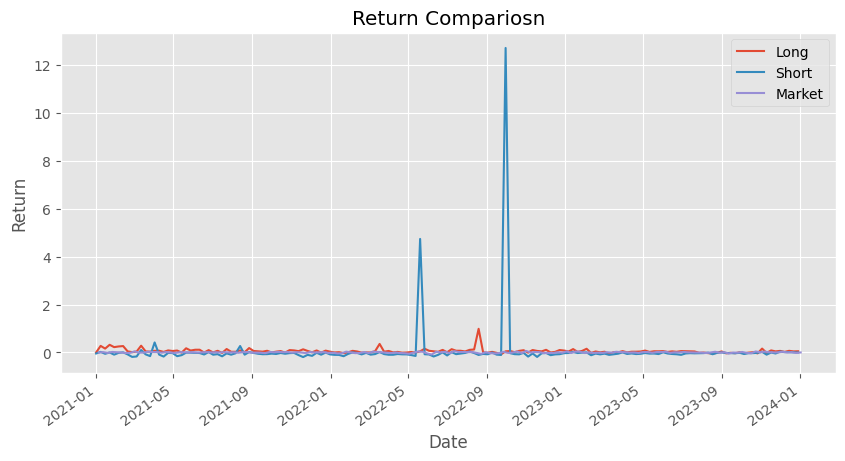

In [129]:
import matplotlib.pyplot as plt

plt.style.use(['ggplot'])

fig, ax = plt.subplots()
# Create a new figure with the desired size
fig.set_size_inches(10, 5)

Moving = 1

ax.plot(result_long.date,result_long.ret.rolling(Moving).mean())
ax.plot(result_short.date,result_short.ret.rolling(Moving).mean())
ax.plot(ret_mk_df.Date,ret_mk_df.ret.rolling(Moving).mean())

ax.set(title = "Return Compariosn", xlabel = "Date", ylabel="Return")

# The 'legend' function takes the labels as a list, so you need to provide them as a list
ax.legend(['Long', 'Short', "Market"])
fig.autofmt_xdate(rotation=36)

plt.show()

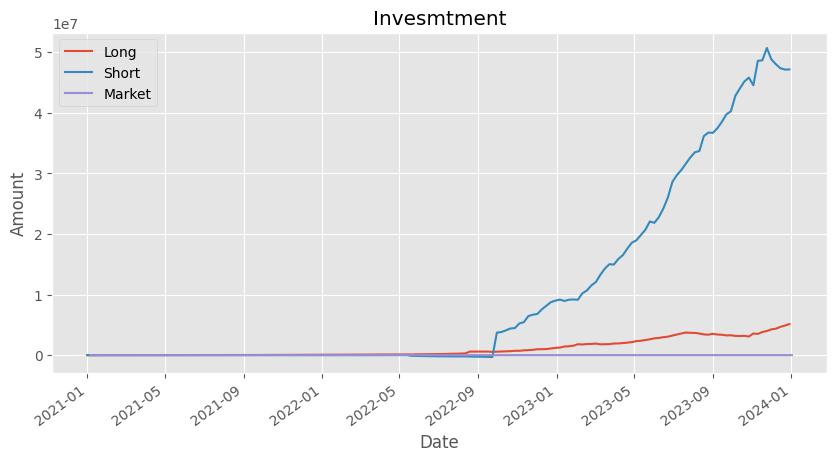

In [131]:
import matplotlib.pyplot as plt

plt.style.use(['ggplot'])

fig, ax = plt.subplots()
# Create a new figure with the desired size
fig.set_size_inches(10, 5)

Moving = 1

ax.plot(result_long.date,(result_long.ret + 1).cumprod()*1000)
#ax.plot(result_short.date,(result_short.ret + 1).cumprod()*1000)
ax.plot(result_short.date,(result_short.ret*-1 + 1).cumprod()*1000)

ax.plot(ret_mk_df.Date,(ret_mk_df.ret + 1).cumprod()*1000)

ax.set(title = "Invesmtment", xlabel = "Date", ylabel="Amount")

# The 'legend' function takes the labels as a list, so you need to provide them as a list
ax.legend(['Long', 'Short', "Market"])
fig.autofmt_xdate(rotation=36)

plt.show()